In [1]:
import higp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
%matplotlib inline

Here we use a synthetic data set with three classes

In [2]:
def generate_data(X):
    Y = np.sin(0.15 * np.pi * np.sum(X, axis=0)) + 2
    Y = np.round(Y).astype(int) - 1  # Labels should be [0, ..., num_classes-1]
    return Y

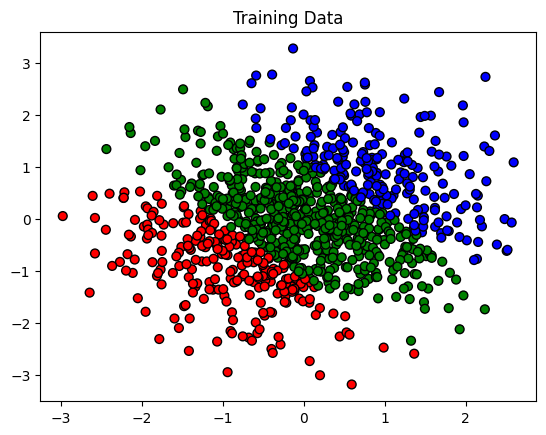

In [3]:
np_dtype = np.float32
n_train = 1000
train_x = np.random.randn(2, n_train).astype(np_dtype)
train_y = generate_data(train_x)

class_cmap = matplotlib.colors.ListedColormap(["red", "green", "blue"])

plt.figure(1)
plt.scatter(train_x[0, :], train_x[1, :], c=train_y, s=40, cmap=class_cmap, edgecolors='k')
plt.title("Training Data")
plt.show()

Create test set by generating linearly spaced points in $[-3,3]$x$[-3,3]$

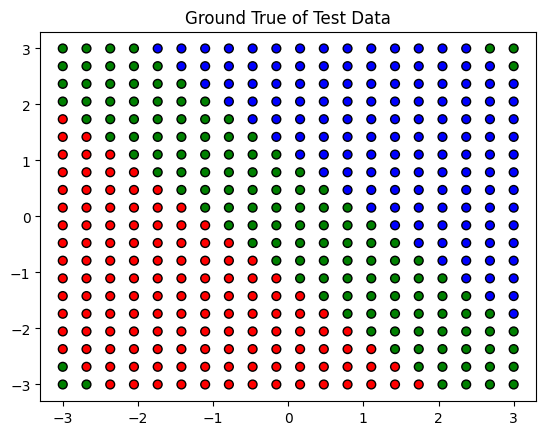

In [4]:
m_pred = 20   # Grid size for test set
x_vals = np.linspace(-3, 3, m_pred)
y_vals = np.linspace(-3, 3, m_pred)
pred_x_x, pred_x_y = np.meshgrid(x_vals, y_vals)
pred_x = np.vstack((pred_x_x.ravel(), pred_x_y.ravel())).astype(np_dtype)
real_y = generate_data(pred_x)
n_pred = len(real_y)

plt.figure(2)
plt.scatter(pred_x[0, :], pred_x[1, :], c=real_y, s=40, cmap=class_cmap, edgecolors='k')
plt.title("Ground True of Test Data")
plt.show()

Create a GP regression model and a PyTorch Adam optimizer.

We use Gaussian kernel by using `higp.GaussianKernel`.

In [5]:
torch_dtype = torch.float32 if np_dtype == np.float32 else torch.float64
gpcproblem = higp.gpcproblem.setup(data=train_x, label=train_y, kernel_type=higp.GaussianKernel)
model = higp.GPCModel(gpcproblem, num_classes=3, dtype=torch_dtype)
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

Run 50 steps of Adam.

In [6]:
loss_history, param_histpry = higp.gpc_torch_minimize(model, optimizer, maxits=50, print_info=False)

Now let's do a prediction using the trained hyperparameters

In [7]:
Pred = higp.gpc_prediction(train_x, train_y, pred_x, higp.GaussianKernel, model.get_params())

Visualize the prediction

In [8]:
def visualize_gpc_prediction(Pred):
    plt.figure(1)
    plt.scatter(pred_x[0, :], pred_x[1, :], c=Pred.prediction_label, s=40, cmap=class_cmap, edgecolors='k')
    plt.title("Prediction of Test Data")
    plt.show()

    plt.figure(2, figsize=(16, 8))
    pred_x1 = pred_x[0, :].reshape(m_pred, m_pred)
    pred_x2 = pred_x[1, :].reshape(m_pred, m_pred)
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        prob_i = Pred.prediction_probability[i, :].reshape(m_pred, m_pred)
        plt.contourf(pred_x1, pred_x2, prob_i, cmap='viridis')
        plt.title(f"Probability of Class {i}")
        plt.colorbar()
    plt.show()

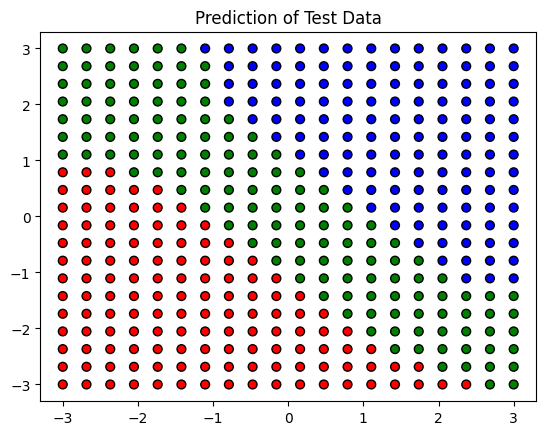

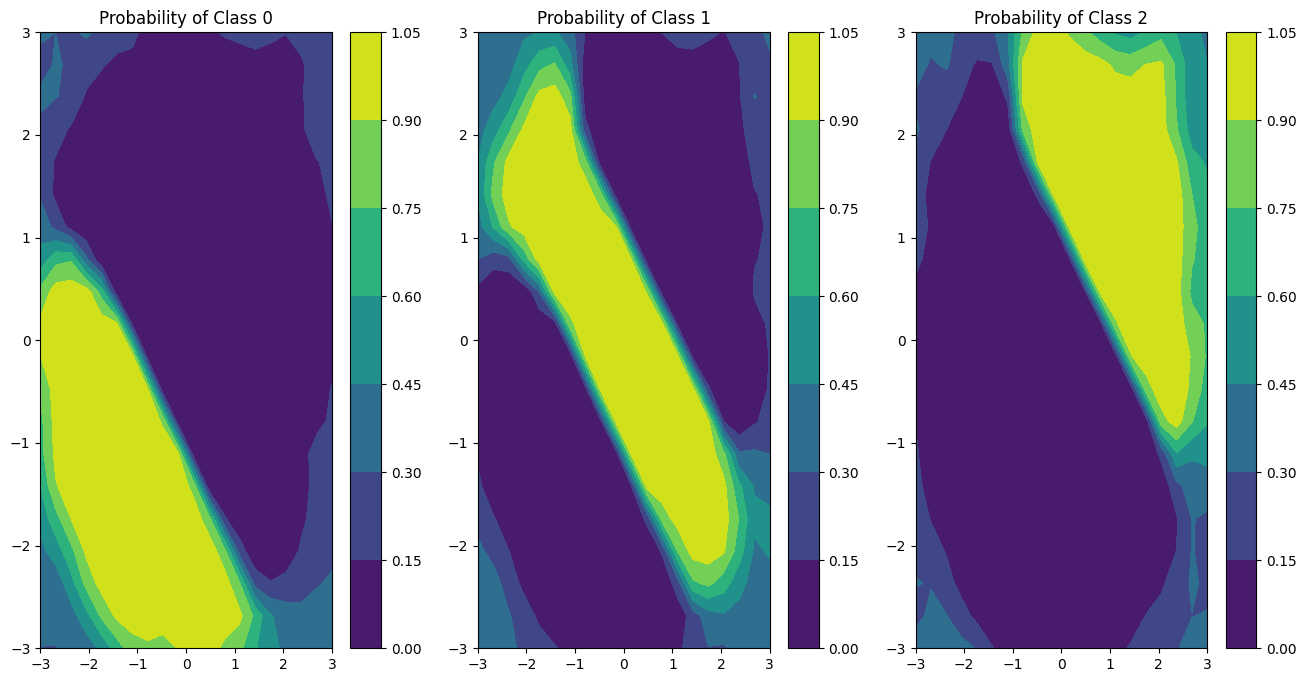

In [9]:
visualize_gpc_prediction(Pred)

We can also use the `ezpgc_troch()` function

In [10]:
Pred2 = higp.ezgpc_torch(train_x, train_y, pred_x, real_y, adam_lr=0.1, adam_maxits=100, print_info=False)

Read 1000 training / 400 test data points
Data dimension: 2
Training time: 3.44126
Prediction time: 1.43731
Prediction accuracy: 0.9425



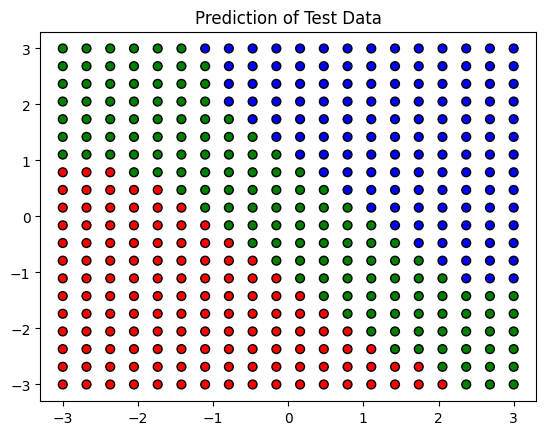

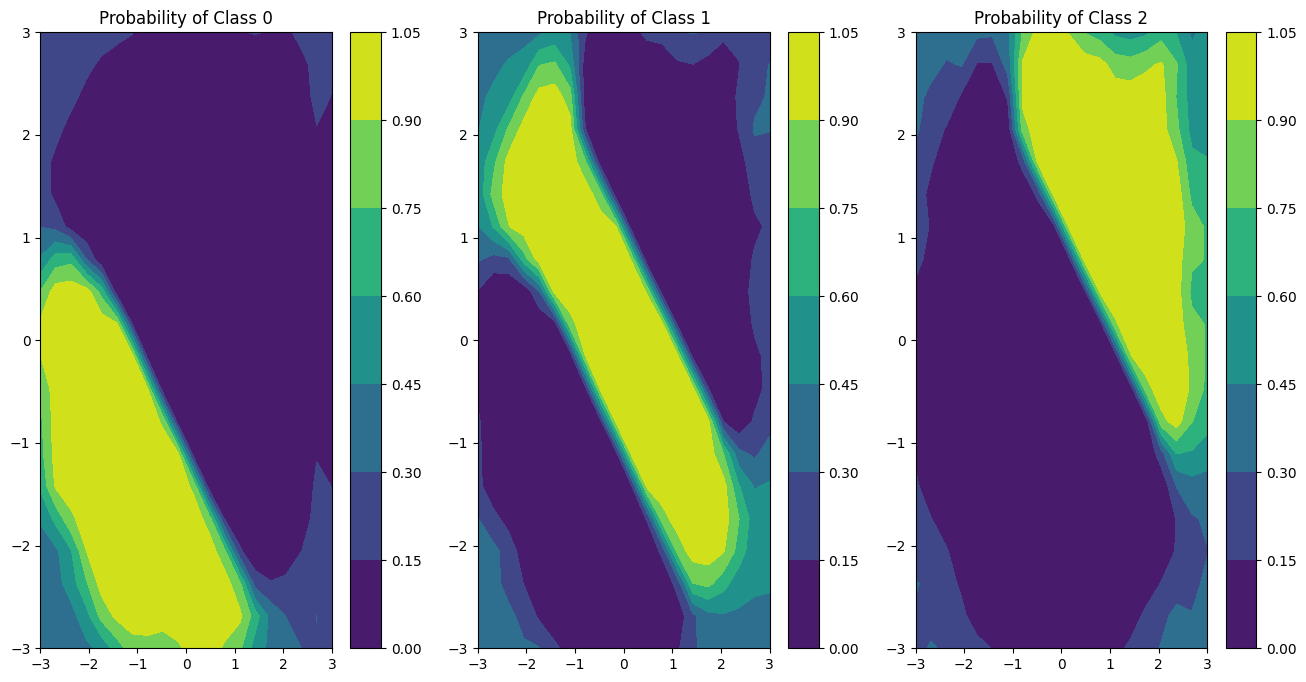

In [11]:
visualize_gpc_prediction(Pred2)